In [3]:
pip install -r requirements.txt

AttributeError: module 'jupyter_core' has no attribute '__version__'

In [1]:
from utils import *
import os
import requests
import zipfile
import numpy as np
import pandas as pd
import geopandas as gpd
from tqdm import tqdm
import pickle
import matplotlib as m
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.dates as dates
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Dataset exploration : 


+ **Goal** : The goal of this notebook is to help us understand the dataset


+ **Source** : [Original dataset](https://drive.google.com/drive/folders/1Wz6D2FM25ydFw_-41I9uTwG9uNsN4TCF?usp=sharing) 

+ **Links** : [Here](../docs/datasets/links.md) is a document with more links about the datasets (parser/crawler, papers, ...)

Now let's look at the all the data available (except reviews that are subsets of ratings)

## File conversion

The txt files from the original dataset have been converted to csv file with the function *ratings_text_to_csv()* in [utils.py](utils.py)

The data loaded, will be the converted one. Here is a link to the [converted dataset](https://drive.google.com/drive/folders/1sbUpQaA4lJ_vyq-aX0h_sRIaG0B6oq_B?usp=drive_link)

In [ ]:
# You need to extract the txt.zip files, and you will need to compress the csv files to csv.zip afterward
#ratings_text_to_csv()

## RAM limitation

If there is to much data to load, you can limit the number of ratings to 'reduced' for each loading of ratings/reviews dataframe. It takes only the first 'reduced' ratings/reviews

Avoid loading data you won't work with

In [ ]:
#REDUCED = None # No reduction
REDUCED = 1e5  # Approx 0.1% of the reviews

## BeerAdvocate

In [ ]:
# Load BeerAdvocate dataset
beers_ba, breweries_ba, users_ba, ratings_ba = load_data('ba', reduced=REDUCED)

### Beers

In [ ]:
# A beer example
beers_ba.sample().T

**Fields description**

***s.e.** means self-explanatory*

+ From BeerAdvocate website :
    * beer_id : s.e.
    * beer_name : s.e.
    * brewery_id : s.e.
    * brewery_name : s.e.
    * style : type of beer such as 'English India Pale Ale (IPA)'
    * nbr_ratings : number of ratings given by the BeerAdvocate community
    * nbr_reviews : same as number of ratings, BUT only includes thoses with at with a text review
    * abv : Alcohol by volume
    * avg : Description on website : "Average across all ratings for this beer", some ratings may be dropped for numerous reasons
    * [ba_score](https://www.beeradvocate.com/community/threads/beeradvocate-ratings-explained.184726/) :

        The BA Score is the beer's overall score based on its ranking within its style category. It's based on the beer's truncated (trimmed) mean and a custom Bayesian (weighted rank) formula that takes the beer's style into consideration. Its purpose is to provide consumers with a quick reference using a format that's familiar to the wine and liquor worlds.

        + 95-100 = world-class
        + 90-94 = outstanding
        + 85-89 = very good
        + 80-84 = good
        + 70-79 = okay
        + 60-69 = poor
        + < 60 = awful
    * bros_score (not used anymore today 2023) : a separate rating provided by the Alström brothers (founders of BA)

+ Computed
    + avg_computed : average of all the ratings about this beer
    + zscore : 
        - Only computed for matched beers --> see matched beer data
        - zscore of the beer rating with the beer ratings of the same year

+ See matched beer data
    * nbr_matched_valid_ratings 
    * avg_matched_valid_ratings 

### Breweries

In [ ]:
breweries_ba.sample().T

**Fields description**

***s.e.** means self-explanatory*

+ From BeerAdvocate website :
    * id : s.e.
    * location : (state, ) country the brewery
    * name : s.e.

+ Computed : 
    * nbr_beers : number of different beers produced by this brewery. Only the beers included in the database are included in the count

### Users

In [ ]:
users_ba.sample().T

**Fields description**

***s.e.** means self-explanatory*

+ From BeerAdvocate website :
    * nbr_ratings : s.e.
    * nbr_reviews : s.e.
    * user_id : s.e.
    * user_name : s.e.
    * joined : timestamp when the user joined the community (day precision, hours always at 12am)
    * location : (state, ) country the user


### Ratings and reviews

In [ ]:
ratings_ba.sample().T

**Fields description**

***s.e.** means self-explanatory*

+ From BeerAdvocate website

    - beer_name : s.e.
    - beer_id : s.e.
    - brewery_name : s.e.
    - brewery_id : s.e.
    - style : type of beer such as 'English India Pale Ale (IPA)'
    - abv : Alcohol by Volume
    - date : timestamp of the rating (day precision, hours always at 12am)
    - user_name : s.e.
    - user_id : s.e.
    * appearance : score on appearance given **by user**, 1 to 5 with resolution at 0.25
    * aroma : score on appearance given **by user**, 1 to 5 with resolution at 0.25
    * palate : score on palate given **by user**, 1 to 5 with resolution at 0.25
    * taste : score on taste given **by user**, 1 to 5 with resolution at 0.25
    * overall : score on overall given **by user**, 1 to 5 with resolution at 0.25
    + rating : 0.06 * appearance + 0.24 * aroma + 0.10 * palate + 0.40 * taste + 0.20 * overall 
        - We found and checked the formula
    * text : the review from the user
    * review : True if the text has at least 150 characters


## RateBeer

In [ ]:
beers_rb, breweries_rb, users_rb, ratings_rb = load_data('rb', reduced=REDUCED)

### Beers

In [ ]:
beers_rb.sample().T

**Fields description**

***s.e.** means self-explanatory*

+ From RateBeer website :
    * beer_id : s.e.
    * beer_name : s.e.
    * brewery_id : s.e.
    * brewery_name : s.e.
    * style : type of beer such as 'India Pale Ale (IPA)'
    * nbr_ratings : number of ratings given by the BeerAdvocate community

    + overall_score : 
        - A score that ranks this beer against all other beers on RateBeer.
        - score up to 100  , nan if no more than 10 ratings
        - RateBeer uses an algorithm when calculating the overall score, considering both the ratings given by each user and the total number of ratings for the beer.
    + style_score : rank among other beer of the same style, nan if no more than 10 ratings. Higher is better
    
    + avg : average rating (some ratings may dropped for numerous reasons) , 1 to 5
    
    * abv : Alcohol by volume
    
+ Computed :
    + avg_computed : average of all the ratings about this beer
    + zscore : 
        - Only computed for matched beers --> see matched beer data
        - zscore of the beer rating with the beer ratings of the same year
    
+ See matched beer data
    * nbr_matched_valid_ratings 
    * avg_matched_valid_ratings 



- About the scores :
    - [Source for the scores explanation](https://www.ratebeer.com/our-scores)
    - **DISCLAIMER** : The link above is the description of 2023, and may not correspond to the scores of the dataset that stop at year 2017
    - Some ratings may not be counted for some score, for number of reasons --> see link above

### Breweries

In [ ]:
breweries_rb.sample().T

**Fields description**

***s.e.** means self-explanatory*

+ From RateBeer website :
    * id : s.e.
    * location : (state, ) country the brewery
    * name : s.e.

+ Computed : 
    * nbr_beers : number of different beers produced by this brewery. Only the beers included in the database are included in the count

### Users

In [ ]:
users_rb.sample().T

**Fields description**

***s.e.** means self-explanatory*

+ From RateBeer website :
    * nbr_ratings : s.e.
    * user_id : s.e.
    * user_name : s.e.
    * joined : timestamp when the user joined the community (day precision, hours always at 12am)
    * location : (state, ) country the user

### Ratings and reviews

In [ ]:
ratings_rb.sample().T

**Fields description**

***s.e.** means self-explanatory*

+ From RateBeer website

    - beer_name : s.e.
    - beer_id : s.e.
    - brewery_name : s.e.
    - brewery_id : s.e.
    - style : type of beer such as 'English India Pale Ale (IPA)'
    - abv : Alcohol by Volume
    - date : timestamp of the rating (day precision, hours always at 12am)
    - user_name : s.e.
    - user_id : s.e.


    * appearance : score on appearance given **by user**, 1 to 5 with resolution at 1
    * aroma : score on appearance given **by user**, 1 to 10 with resolution at 1
    * palate : score on palate given **by user**, 1 to 5 with resolution at 1
    * taste : score on taste given **by user**, 1 to 10 with resolution at 1
    * overall : score on overall given **by user**, 1 to 20 with resolution at 1
    + rating :  sum of the 5 previous scores divided by 10
        - We found and checked the formula. It works almost everytime (99.9996%)
    * text : the review from the user


## Matched beer data

[matching method](https://github.com/epfl-dlab/when_sheep_shop/blob/master/code/notebooks/1-matching.ipynb)

In [ ]:
beers_matched, breweries_matched, users_matched, ratings_matched = load_data('matched', reduced=REDUCED)
(users_matched, users_approx_matched) = users_matched
(ratings_matched, ratings_ba_matched, ratings_rb_matched) = ratings_matched

### Breweries

**How the matching is done**:

Breweries are matched on the name (cosine **sim** of at least 0.8 and **diff**erence between first and second match of at least 0.3) and on the location (exact match)

*Explanation of sim and diff fields above*

In [ ]:
breweries_matched.head(2).T

**Fields** : All the fields are either explained above or self explanatory

### Beers


**How the matching is done**:

Beers are matched on the name without the brewery name (cosine **sim** of at least 0.8 and **diff**erence between first and second match of at least 0.4) from the matched breweries and on their ABV (exact match)

*Explanation of sim and diff fields above*

+ nbr_matched_valid_ratings : number of matched ratings with the condition stated above
+ avg_matched_valid_ratings : average rating of the matched ratings

In [ ]:
beers_matched.head(2).T

**Fields** : All the fields are either explained above or self explanatory

### Users and users_approx


**How the matching is done**:

- users : The users are matched on their username and their location (exact matches). The usernames are transformed into only lowercase letters.
- users_approx : The users are matched on their username and their location (cosine **sim** of at least 0.9). The usernames are transformed into only lowercase letters.

*Explanation of sim and diff fields above*

In [ ]:
users_matched.head(2).T

In [ ]:
users_approx_matched.head(2).T

**Fields** : All the fields are either explained above or self explanatory

### All ratings

Match ratings with matched user and matched beer

* ratings_matched : All matched ratings
* ratings_ba_matched : All matched ratings from BeerAdvocate
* ratings_rb_matched : All matched ratings from RateBeer
* ratings_with_text_ba_matched : All matched ratings from BeerAdvocate, with review == True
* ratings_with_text_rb_matched : All matched ratings from RateBeer, with a text review

Every fields have been explained above

In [ ]:
ratings_matched.head(2).T

In [ ]:
ratings_ba_matched.sample().T

In [ ]:
ratings_rb_matched.sample().T

# Data preprocessing : 

## Goal: Preprocess the dataset
- Handle nan values
- Type conversion
- Transform numerical values

## Main points from [data exploration](1.exploration.ipynb)

**Datasets nomenclature**
- BeerAdvocate : BA or ba
- RateBeer : RB or rb
- Matched_beer_data : MBD or matched

**Rating ranges and formulas**
- The score appearance, aroma, palate, taste, overall **ranges** and **resolution** in ba and rb :
    - BA 
        + ranges (resp.) : 1-5,1-5,1-5,1-5,1-5  
        + with 0.25 resolution
    - RB 
        + ranges (resp.) : 1-5,1-10,1-5,1-10,1-20 
        + with 1 resolution
- the **rating is a linear combination** of the 5 mentioned score above
    - BA rating 
        + rating = 0.06 * appearance + 0.24 * aroma + 0.10 * palate + 0.40 * taste + 0.20 * overall 
        + range from 1 to 5
    - RB rating 
        + rating = 0.1 * appearance + 0.1 * aroma + 0.1 * palate + 0.1 * taste + 0.1 * overall
        + range from 1 to 5

    + Therefore the ratings from both datasets are not comparable

**Aggragated scores from all users** 

+ BOTH : **z-score is only computed** for data occuring **in MBD**
    - The z-score of a beer, is the z-score of with all the ratings of the same beer occuring the **same year**
+ BOTH : avg_computed may differ from avg, since ba and rb drops some ratings on some criterion


+ BA : bros_score in the BA dataset is a score given by the founders of BA 
+ BA : ba_score is the score of the beer by the BA community, see description [here](https://www.beeradvocate.com/community/threads/beeradvocate-ratings-explained.184726/)


+ RB : style score is a ranking of the beer among the beer of the same style. High rank (e.g 80 is better than 3 for beer of the same style)

+ RB : overall score is in range (1-100) and is a score to rank all the beers on RB
    - RateBeer uses an algorithm when calculating the overall score, considering both the ratings given by each user and the total number of ratings for the beer. Need at least 10 ratings

## Load data

**Downloading and unziping data**

In [6]:
if not os.path.isdir('../data/'):
    os.mkdir('../data')
    os.mkdir('../data/preprocessed')
    os.mkdir('../data/preprocessed/BeerAdvocate')
    os.mkdir('../data/preprocessed/RateBeer')

    # download data for RateBeer
    print('downloading data from RateBeer...')
    url = 'https://enacshare.epfl.ch/feztsAxLPobV3RgZpMJ7vuHYKB9XicN'
    path = '../data/RateBeer.zip'
    r = requests.get(url, allow_redirects=True)
    open(path, 'wb').write(r.content)
    with zipfile.ZipFile(path, 'r') as zip_ref:
        zip_ref.extractall('../data/')
    
    # download data for BeerAdvocate
    print('downloading data from BeerAdvocate...')
    url = 'https://enacshare.epfl.ch/f3HwZ5QxprJbsLu6c92qmeRvoYiahVT'
    path = '../data/BeerAdvocate.zip'
    r = requests.get(url, allow_redirects=True)
    open(path, 'wb').write(r.content)
    with zipfile.ZipFile(path, 'r') as zip_ref:
        zip_ref.extractall('../data/')
    print('done')
    os.remove('../data/BeerAdvocate.zip')
    os.remove('../data/RateBeer.zip')

if not os.path.isdir('./variables/'):
    print('Unziping preprocessed variables...')
  
    with zipfile.ZipFile('./variables.zip', 'r') as zip_ref:
        zip_ref.extractall('./')
    print('done')

downloading data from RateBeer...
downloading data from BeerAdvocate...
done
Unziping preprocessed variables...
done


**Dataset prefiltering**
- reviews are just the ratings that contain a text review. To avoid duplicates let's not load it
- MBD do not give us the information we need. Let's not load it
    + We won't use the already computed z-score, since it's limited to this dataset

**RAM limitation :**

In [7]:
REDUCED = None
#REDUCED = 2e6  # 1e6 <=> Approx 25% of the ratings (approx : 3Gb), set to None to load all the data

**Loading**

In [8]:
%%time
beers_ba, breweries_ba, users_ba, ratings_ba = load_data('ba', REDUCED)
beers_rb, breweries_rb, users_rb, ratings_rb = load_data('rb', REDUCED)

CPU times: total: 1min 8s
Wall time: 1min 25s


## Filtering out useless information/Nan

In [9]:
# Drop information about MBD
beers_ba = beers_ba.drop(['zscore','nbr_matched_valid_ratings','avg_matched_valid_ratings'], axis=1)
beers_rb = beers_rb.drop(['zscore','nbr_matched_valid_ratings','avg_matched_valid_ratings'], axis=1)

# Drop beers without more than 'min_ratings' ratings
n_beers_ba = len(beers_ba) 
n_beers_rb = len(beers_rb)

min_ratings = 0 
print(f'Filtering out all beers with {min_ratings} ratings or less')
beers_ba = beers_ba[beers_ba.nbr_ratings>min_ratings]
beers_rb = beers_rb[beers_rb.nbr_ratings>min_ratings]

# Drop beers with important information missing
beers_ba = beers_ba.dropna(subset=['abv'])
beers_rb = beers_rb.dropna(subset=['abv'])

print(f'Beers kept : ')
print(f'\t BA : {len(beers_ba)}/{n_beers_ba}')
print(f'\t RB : {len(beers_rb)}/{n_beers_rb}')

# Filter out breweries with only beers that have been filtered out
n_breweries_ba = len(breweries_ba) 
n_breweries_rb = len(breweries_rb) 
breweries_ba = breweries_ba[breweries_ba['id'].isin(beers_ba['brewery_id'])]
breweries_rb = breweries_rb[breweries_rb['id'].isin(beers_rb['brewery_id'])]
print(f'Breweries kept : ')
print(f'\t BA : {len(breweries_ba)}/{n_breweries_ba}')
print(f'\t RB : {len(breweries_rb)}/{n_breweries_rb}')

# Filter out ratings about beers that have been filtered out
n_ratings_ba = len(ratings_ba)
n_ratings_rb = len(ratings_rb)
ratings_ba = ratings_ba[ratings_ba['beer_id'].isin(beers_ba['beer_id'])]
ratings_rb = ratings_rb[ratings_rb['beer_id'].isin(beers_rb['beer_id'])]
print(f'Ratings kept : ')
print(f'\t BA : {len(ratings_ba)}/{n_ratings_ba}')
print(f'\t RB : {len(ratings_rb)}/{n_ratings_rb}')

Filtering out all beers with 0 ratings or less
Beers kept : 
	 BA : 217107/280823
	 RB : 359958/442081
Breweries kept : 
	 BA : 12934/16758
	 RB : 20804/24189
Ratings kept : 
	 BA : 8221727/8393032
	 RB : 6947090/7122074


## Populate ratings with location of beer and user

In [10]:
# Rename location variable in users and breweries
users_ba.rename(columns={'location':'user_location'}, inplace=True)
breweries_ba.rename(columns={'location':'brewery_location', 'id':'brewery_id', 'nbr_beers':'nbr_beers_by_brewery'}, inplace=True)
users_rb.rename(columns={'location':'user_location'}, inplace=True)
breweries_rb.rename(columns={'location':'brewery_location', 'id':'brewery_id', 'nbr_beers':'nbr_beers_by_brewery'}, inplace=True)

# Populate ratings with locations from users and breweries
ratings_ba = pd.merge(left=ratings_ba, right=users_ba[['user_id', 'user_location']], on='user_id', how='left')
ratings_ba = pd.merge(left=ratings_ba, right=breweries_ba[['brewery_id', 'brewery_location', 'nbr_beers_by_brewery']], on='brewery_id', how='left')
ratings_rb = pd.merge(left=ratings_rb, right=users_rb[['user_id', 'user_location']], on='user_id', how='left')
ratings_rb = pd.merge(left=ratings_rb, right=breweries_rb[['brewery_id', 'brewery_location', 'nbr_beers_by_brewery']], on='brewery_id', how='left')

## Transform ratings to normal distribution and compute zscore

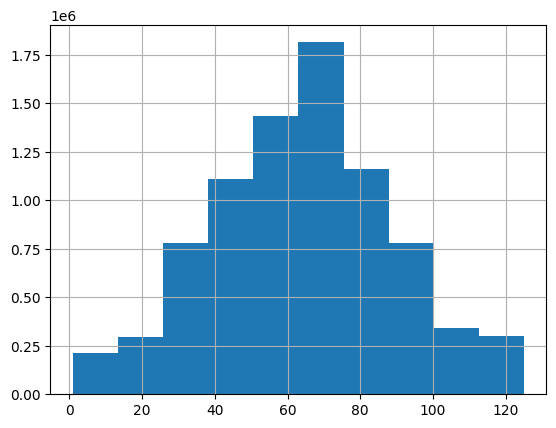

In [11]:
ratings_ba.rating.apply(lambda x: x**3).hist()
ratings_ba['zscore'] = ratings_ba['rating'].apply(lambda x: x**3)
ratings_ba['zscore'] = (ratings_ba['zscore']-ratings_ba['zscore'].mean())/ratings_ba['zscore'].std()

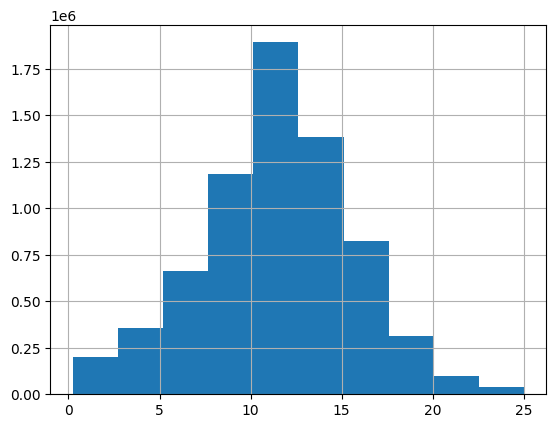

In [12]:
ratings_rb.rating.apply(lambda x: x**2).hist()
ratings_rb['zscore'] = ratings_rb['rating'].apply(lambda x: x**2)
ratings_rb['zscore'] = (ratings_rb['zscore']-ratings_rb['zscore'].mean())/ratings_rb['zscore'].std()

## Save transformed ratings

In [13]:
ratings_ba.sample(frac=0.1, random_state=42).to_pickle('../data/preprocessed/BeerAdvocate/transformed_ratings_ba.pkl')
ratings_rb.sample(frac=0.1, random_state=42).to_pickle('../data/preprocessed/RateBeer/transformed_ratings_rb.pkl')
ratings_ba.sample(frac=1.0, random_state=42).to_pickle('../data/preprocessed/BeerAdvocate/transformed_ratings_ba_full.pkl')
ratings_rb.sample(frac=1.0, random_state=42).to_pickle('../data/preprocessed/RateBeer/transformed_ratings_rb_full.pkl')

# Beer type preferences

## Functions

In [ ]:
def get_LR(data, columns):
    data_to_process = data.copy() # copy original dataset
    
    # create formula
    columns=list(columns)
    formula = 'rating ~ ' + columns[0]
    for el in columns[1:-1]:
        formula += ' + ' + el
    
    # standardization and creation of the formula
    columns.append('rating')  # add rating for the linear regression and standardization
    data_to_process = data_to_process[columns].dropna().sample(frac=1)  # only keeps columns of interest and shuffle the samples
    data_to_process['rating'] = (data_to_process['rating'] - data_to_process['rating'].mean()) / data_to_process['rating'].std()
    
    # create the model and fit it to the dataset
    mod = smf.ols(formula=formula, data=data_to_process)
    np.random.seed(2)
    res = mod.fit()
    return res

In [ ]:
def styles_rephrase(lst_styles):
    # replace some characters
    old_values = [' ', '-', '/', '(', ')', '&', ',', '____', '___', '__', 'style_']
    for val in old_values:
        lst_styles = lst_styles.str.replace(val,'_')
    
    # remove '_' if in first or last position of style name
    lst_styles = [x.rstrip('_') for x in lst_styles]
    lst_styles = [x.lstrip('_') for x in lst_styles]
    
    return lst_styles

In [ ]:
def get_category(df):
    # rephrase styles
    old_values = [' ', '-', '/', '\(', '\)', '\&', ',']
    df.replace(
        to_replace={'style':old_values},
        value='_',
        regex=True,
        inplace=True,
    )
    df.replace(
        to_replace={'style':'____'},
        value='_',
        regex=True,
        inplace=True,
    )
    df.replace(
        to_replace={'style':'___'},
        value='_',
        regex=True,
        inplace=True,
    )
    df.replace(
        to_replace={'style':'__'},
        value='_',
        regex=True,
        inplace=True,
    )
    df['style'] = df['style'].str.strip('_')

    # load csv
    df_styles_to_cat = pd.read_csv('./styles_to_categories.csv', sep=';')

    # add category for each review
    df['category'] = "nothing"
    for cat in df_styles_to_cat.columns:
        for style in df_styles_to_cat[cat].dropna():
            df.loc[df['style'] == style, 'category'] = cat

    # remove elements with unknown style
    num_wrong_style = len(df[df.category == 'nothing'])
    if num_wrong_style > 0:
        df = df[df.category != 'nothing']
        print(f"{num_wrong_style} element removed because of unknown style")

    return df

## Loading and selecting data

In [ ]:
df_ba = pd.read_pickle('../data/preprocessed/BeerAdvocate/transformed_ratings_ba.pkl')
df_rb = pd.read_pickle('../data/preprocessed/RateBeer/transformed_ratings_rb.pkl')

In [ ]:
df_ba_style = df_ba[['beer_id', 'beer_name', 'brewery_id', 'brewery_name', 'brewery_location', 'user_location', 'style','rating']]
df_rb_style = df_rb[['beer_id', 'beer_name', 'brewery_id', 'brewery_name', 'brewery_location', 'user_location', 'style','rating']]

# creating dataframe for styles/category analysis
df_styles_reviews = pd.concat([df_ba_style, df_rb_style]).reset_index().drop('index', axis=1).dropna()
df_styles_reviews['brewery_location'] = df_styles_reviews['brewery_location'].str.replace("United States, ", "")
df_styles_reviews['user_location'] = df_styles_reviews['user_location'].str.replace("United States, ", "")

## Sorting by countries

In [ ]:
user_loc_count = df_styles_reviews.groupby(['user_location'])['user_location'].count().sort_values(ascending=False)

# select countries with more than 100 reviews:
user_loc_count = user_loc_count[user_loc_count > 100]
print(f"Number of countries selected: {len(user_loc_count)}")

## Finding favourite category

In [ ]:
df_cat_location_dumm = pd.get_dummies(df_styles_reviews, columns=['category'])
best_cat_per_user_location = {}

# remove special characters in columns names
df_cat_location_dumm.columns = df_cat_location_dumm.columns.str.replace('category_', '')

# transform boolean values to int values for linear regression
for col in df_cat_location_dumm.drop(['beer_id', 'beer_name', 'brewery_name', 'brewery_location','user_location', 'brewery_id', 'rating','style'], axis=1).columns:
    df_cat_location_dumm[col] = df_cat_location_dumm[col] * 1

# perform linear regression on each location
columns= list(df_cat_location_dumm.drop(['beer_id', 'beer_name', 'user_location', 'brewery_name', 'brewery_location', 'brewery_id', 'rating', 'style'], axis=1).columns)
for idx, loc in enumerate(list(user_loc_count.keys())):
    df_reviews = df_cat_location_dumm[df_styles_reviews['user_location'] == loc]
    res = get_LR(df_reviews, columns)
    best_cat_per_user_location[loc] = res.params[res.params.keys() != 'Intercept'].sort_values(ascending=False)[0:3]

# save dictionary in pickle for other analysis
with open('./variables/best_cat_per_user_location.pickle', 'wb') as f:
    pickle.dump(best_cat_per_user_location, f, protocol=pickle.HIGHEST_PROTOCOL)

## Finding most reviewed category

In [ ]:
most_reviewed_cat_per_user_location = {}
for idx, loc in enumerate(list(user_loc_count.keys())):
    most_reviewed_cat_per_user_location[loc] = df_styles_reviews[df_styles_reviews['user_location']==loc].groupby(['category'])['category'].count().sort_values(ascending=False)[:3]

## Finding local breweries

In [ ]:
frac_reviews_per_brewery = {}

# loop on every location
for idx, loc in tqdm(enumerate(list(user_loc_count.keys())), total=len(list(user_loc_count.keys()))):

    # total number of reviews per brewery
    num_reviews_per_brewery = df_styles_reviews[df_styles_reviews['brewery_location'] == loc] \
    .groupby(['brewery_name'])['brewery_name'] \
    .count() \
    .sort_values(ascending=False)

    # number of local reviews per brewery
    num_reviews_per_brewery_loc = df_styles_reviews[(df_styles_reviews['brewery_location'] == loc) & (df_styles_reviews['user_location'] == loc)] \
    .groupby(['brewery_name'])['brewery_name'] \
    .count() \
    .sort_values(ascending=False)

    num_reviews_per_brewery.keys = num_reviews_per_brewery_loc.keys
    num_reviews_per_brewery = num_reviews_per_brewery.loc[num_reviews_per_brewery_loc.keys()]

    # fraction of local rewviews per brewery (50% and up)
    frac_reviews_per_brewery[loc] = num_reviews_per_brewery_loc.divide(num_reviews_per_brewery).sort_values(ascending=False)
    frac_reviews_per_brewery[loc] = frac_reviews_per_brewery[loc][frac_reviews_per_brewery[loc].values > .5]
    

In [ ]:
# removing the locations with no "local" breweries (meaning that there is no brewery with high enough fraction of local reviewers)
init_num_loc = len(frac_reviews_per_brewery)
lst_empty_loc = []
for loc in frac_reviews_per_brewery:
    if len(frac_reviews_per_brewery[loc]) == 0:
        lst_empty_loc.append(loc)
for loc in lst_empty_loc:
    frac_reviews_per_brewery.pop(loc)
lst_locations = list(frac_reviews_per_brewery.keys())

print(f"{str(init_num_loc - len(lst_locations))} locations where removed")

## Looking for each country if local breweries is answering to local preferences

### Get the global average representation of each style

#### Find values for "difference" computation

In [ ]:
retrain_glob_frac = False
if retrain_glob_frac:
    global_frac_per_cat = {}
    for cat in df_styles_reviews.category.unique():
        print(f"Compute for {cat}...")
        global_frac_per_cat[cat] = 0
        for brewery in list(df_styles_reviews.brewery_name.unique()):
            df_brewery = df_styles_reviews[df_styles_reviews['brewery_name'] == brewery][['category','brewery_name']]
            val = list(df_brewery[df_brewery['category'] == cat].groupby('category')['category'].count()/len(df_brewery))
            if val != []:
                global_frac_per_cat[cat] += val[0]
        global_frac_per_cat[cat] /= len(df_styles_reviews.brewery_name.unique())

    # save dictionaries
    with open('./variables/global_frac_per_cat.pickle', 'wb') as handle:
        pickle.dump(global_frac_per_cat, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open('./variables/global_frac_per_cat.pickle', 'rb') as handle:
        global_frac_per_cat = pickle.load(handle)

#### Find lists for "zscore" computation

In [ ]:
do_retrain_glob_frac_lst = False
if do_retrain_glob_frac_lst:
    global_frac_per_cat_lst = {}
    for cat in df_styles_reviews.category.unique():
        print(f"Compute for {cat}...")
        global_frac_per_cat_lst[cat] = []
        breweries = list(df_styles_reviews.brewery_name.unique())
        for brewery in breweries:
            df_brewery = df_styles_reviews[df_styles_reviews['brewery_name'] == brewery][['category','brewery_name']]
            val = list(df_brewery[df_brewery['category'] == cat].groupby('category')['category'].count()/len(df_brewery))
            if val != []:
                global_frac_per_cat_lst[cat].append(val[0])
            else:
                global_frac_per_cat_lst[cat].append(0)
                
    # save dictionaries
    with open('./variables/global_frac_per_cat_lst.pickle', 'wb') as handle:
        pickle.dump(global_frac_per_cat_lst, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open('./variables/global_frac_per_cat_lst.pickle', 'rb') as handle:
        global_frac_per_cat_lst = pickle.load(handle)

In [ ]:
# find mean and std for zscore
global_frac_per_cat_lst_mean = {}
global_frac_per_cat_lst_std = {}
for cat in df_styles_reviews.category.unique():
    global_frac_per_cat_lst_mean[cat] = np.mean(np.asarray(global_frac_per_cat_lst[cat]))
    global_frac_per_cat_lst_std[cat] = np.std(np.asarray(global_frac_per_cat_lst[cat]))

### Compare for each location

In [ ]:
do_compare_loc = False
if do_compare_loc == True:
    # loop on every location
    frac_per_loc_per_cat = {}
    for idx, loc in tqdm(enumerate(lst_locations), total=len(lst_locations)):
        breweries = frac_reviews_per_brewery[loc].keys()
        cats = best_cat_per_user_location[loc].keys()
        frac_per_loc_per_cat[loc] = {}
        for cat in cats:
            frac_per_loc_per_cat[loc][cat] = 0
            for brewery in breweries:
                df_brewery = df_styles_reviews[df_styles_reviews['brewery_name'] == brewery][['category','brewery_name']]
                val = list(df_brewery[df_brewery['category'] == cat].groupby('category')['category'].count()/len(df_brewery))

                if val != []:
                    frac_per_loc_per_cat[loc][cat] += val[0]
                
            if len(breweries) > 0:
                frac_per_loc_per_cat[loc][cat] /= len(breweries)
            else:
                print("No breweries for : " + loc)
    
    # save library
    with open('./variables/frac_per_loc_per_cat.pickle', 'wb') as handle:
        pickle.dump(frac_per_loc_per_cat, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open('./variables/frac_per_loc_per_cat.pickle', 'rb') as handle:
        frac_per_loc_per_cat = pickle.load(handle)

In [ ]:
# compute diff and z-score
diff_frac_per_loc_per_cat = {}
zscore_frac_per_loc_per_cat = {}
for loc in lst_locations:
    diff_frac_per_loc_per_cat[loc] = {}
    zscore_frac_per_loc_per_cat[loc] = {}
    for cat in frac_per_loc_per_cat[loc]:
        diff_frac_per_loc_per_cat[loc][cat] = frac_per_loc_per_cat[loc][cat] - global_frac_per_cat[cat]
        zscore_frac_per_loc_per_cat[loc][cat] = (frac_per_loc_per_cat[loc][cat] - global_frac_per_cat_lst_mean[cat]) / global_frac_per_cat_lst_std[cat]

## Looking for each country if local breweries is answering to most reviewed

### Compare for each location

In [ ]:
do_compare_loc_2 = False
if do_compare_loc_2 == True:
    # loop on every location
    frac_per_loc_per_cat_2 = {}
    for idx, loc in tqdm(enumerate(lst_locations), total=len(lst_locations)):
        breweries = frac_reviews_per_brewery[loc].keys()

        #styles = styles_rephrase(best_type_per_user_location[loc].keys())
        cats = most_reviewed_cat_per_user_location[loc].keys()
        frac_per_loc_per_cat_2[loc] = {}
        for cat in cats:
            frac_per_loc_per_cat_2[loc][cat] = 0
            for brewery in breweries:
                df_brewery = df_styles_reviews[df_styles_reviews['brewery_name'] == brewery][['category','brewery_name']]
                val = list(df_brewery[df_brewery['category'] == cat].groupby('category')['category'].count()/len(df_brewery))

                if val != []:
                    frac_per_loc_per_cat_2[loc][cat] += val[0]
                
            if len(breweries) > 0:
                frac_per_loc_per_cat_2[loc][cat] /= len(breweries)
            else:
                print("No breweries for : " + loc)
                
    # save library
    with open('./variables/frac_per_loc_per_cat_2.pickle', 'wb') as handle:
        pickle.dump(frac_per_loc_per_cat_2, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open('./variables/frac_per_loc_per_cat_2.pickle', 'rb') as handle:
        frac_per_loc_per_cat_2 = pickle.load(handle)

In [ ]:
# compute diff and zscore for most reviewes analysis
diff_frac_per_loc_per_cat_ana2 = {}
zscore_frac_per_loc_per_cat_ana2 = {}
for loc in lst_locations:
    diff_frac_per_loc_per_cat_ana2[loc] = {}
    zscore_frac_per_loc_per_cat_ana2[loc] = {}
    for cat in frac_per_loc_per_cat_2[loc]:
        diff_frac_per_loc_per_cat_ana2[loc][cat] = frac_per_loc_per_cat_2[loc][cat] - global_frac_per_cat[cat]
        zscore_frac_per_loc_per_cat_ana2[loc][cat] = (frac_per_loc_per_cat_2[loc][cat] - global_frac_per_cat_lst_mean[cat]) / global_frac_per_cat_lst_std[cat]


## Show results

### Load and merge shapefiles

In [ ]:
# Load shapefiles
world = gpd.read_file('../data/shapefiles/world-administrative-boundaries.zip')
states = gpd.read_file('../data/shapefiles/georef-united-states-of-america-state-millesime.zip')

# clean world
world_clean = world[world['name'] != 'United States of America'][['name','geometry']]
world_clean.name = world_clean.name.str.replace("U.K. of Great Britain and Northern Ireland", "England")

# clean states
states.ste_name = states.ste_name.str.replace("['", "")
states.ste_name = states.ste_name.str.replace("']", "")
states_clean = states[['ste_name','geometry']]
states_clean.rename({'ste_name':'name'}, inplace=True, axis=1)

# concatenate
shapefile = pd.concat([world_clean, states_clean], axis=0)

### Show main category per location

In [ ]:
sf_maincat = shapefile.copy()

# find main category
sf_maincat['main_cat'] = "None"
for loc in lst_locations:
    sf_maincat.loc[sf_maincat['name'] == loc, 'main_cat'] = best_cat_per_user_location[loc].keys()[0]

In [ ]:
# color map
color_map = ['orange','#dddddd','brown','green','#555555']
# Plot the main predictor on a world map
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
sf_maincat.plot(column='main_cat', cmap=colors.ListedColormap(color_map), ax=ax, legend=True, categorical=True)
plt.title('Prefered Category by Country')
plt.axis('off')
plt.savefig('../results/map_pref_cat.png')
plt.show()

### Show how breweries adapt to local preferences

In [ ]:
sf_local_breweries = shapefile.copy()

# add zscore
sf_local_breweries['zscore'] = 0
for loc in lst_locations:
    sf_local_breweries.loc[sf_local_breweries['name'] == loc, 'zscore'] = np.sum(np.asarray(list(zscore_frac_per_loc_per_cat[loc].values())))/3

In [ ]:
# Plot the main predictor on a world map
fig, ax = plt.subplots(1, 1, figsize=(14,8))

sf_maincat.boundary.plot(ax=ax, linewidth=.2, color='black')
im = sf_local_breweries.plot(column='zscore', cmap='RdBu', ax=ax, legend=True, legend_kwds={"label": "Z-score", "orientation": "horizontal"}, vmin=-1.2, vmax=1.2)

plt.title('Tendancy of local breweries to produce preferred categories')
plt.axis('off')
plt.savefig('../results/map_local_breweries.png')
plt.show()

### Show how breweries adapt to local most reviewed

In [ ]:
sf_local_breweries2 = shapefile.copy()

# add zscore
sf_local_breweries2['zscore'] = 0
for loc in lst_locations:
    sf_local_breweries2.loc[sf_local_breweries2['name'] == loc, 'zscore'] = np.sum(np.asarray(list(zscore_frac_per_loc_per_cat_ana2[loc].values())))/3

In [ ]:
# Plot the main predictor on a world map
fig, ax = plt.subplots(1, 1, figsize=(14,8))

sf_local_breweries2.boundary.plot(ax=ax, linewidth=.2, color='black')
sf_local_breweries2.plot(column='zscore', cmap='RdBu', ax=ax, legend=True, legend_kwds={"label": "Z-score", "orientation": "horizontal"}, vmin=-0.8, vmax=0.8)

plt.title('Tendancy of local breweries to produce most reviewed categories')
plt.axis('off')
plt.savefig('../results/map_local_breweries_most_reviewed.png')
plt.show()

## Check for temporal trends between evolution of frac in reviews and frac in breweries propositions

### Find first review date for each beer

In [ ]:
first_date_per_beer = {}
do_list_beers = False
if do_list_beers:
    # load full datasets
    df_ba_full = pd.read_pickle('../data/preprocessed/BeerAdvocate/transformed_ratings_ba_full.pkl')
    df_rb_full = pd.read_pickle('../data/preprocessed/RateBeer/transformed_ratings_rb_full.pkl')
    
    # fing beers of beerdavocate (and also look for same beers in ratebeer)
    print('Looking into BeerAdvocate...')
    for idx, beer_id in tqdm(enumerate(list(df_ba_full.beer_id.unique())), total=len(list(df_ba_full.beer_id.unique()))):
        df_ba_beer = df_ba_full[df_ba_full['beer_id'] == beer_id][['beer_id', 'beer_name','date','style','brewery_name']]
        df_rb_beer = df_rb_full[df_rb_full['beer_id'] == beer_id][['beer_id', 'beer_name','date','style','brewery_name']]
        df_beer = pd.concat([df_ba_beer,df_rb_beer], axis=0)

        # add the first date appearing for this beer
        first_date_per_beer[beer_id] = df_beer.sort_values(by='date').iloc[0]

    # find beers of ratebeer that are not in beeradvocate
    print('Looking into RateBeer...')
    list_ba_beers = list(df_ba_full.beer_id.unique())
    list_rb_beers = list(df_rb_full.beer_id.unique())
    list_rb_to_process = list(set(list_rb_beers) - set(list_ba_beers))
    for idx, beer_id in tqdm(enumerate(list_rb_to_process), total=len(list_rb_to_process)):
        df_rb_beer = df_rb_full[df_rb_full['beer_id'] == beer_id][['beer_id', 'beer_name','date','style','brewery_name']]

        # add the first date appearing for this beer
        first_date_per_beer[beer_id] = df_rb_beer.sort_values(by='date').iloc[0]
    
    # save dictionary
    with open('./variables/first_date_per_beer.pickle','wb') as f:
        pickle.dump(first_date_per_beer, f, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open('./variables/first_date_per_beer.pickle','rb') as f:
        first_date_per_beer = pickle.load(f)

In [ ]:
# select only beers related to the subsample analysis
list_beers_analysis = list(df_styles_reviews.beer_id.unique())
first_date_per_beer = {key:first_date_per_beer[key] for key in list_beers_analysis}
df_first_date_per_beer = pd.DataFrame(first_date_per_beer).transpose().reset_index().drop('index',axis=1)

print(f"{len(df_first_date_per_beer)} beers selected")


### Compute time serie of frac per beers

In [ ]:
# add category
df_first_date_per_beer = get_category(df_first_date_per_beer)


In [ ]:
df_ba_date = df_ba[['date','style']]
df_rb_date = df_rb[['date','style']]
df_date_reviews = pd.concat([df_ba_date, df_rb_date]).reset_index().drop('index', axis=1).dropna()

# add category
df_date_reviews = get_category(df_date_reviews)

In [ ]:
dic_date_cat_frac = {}
do_find_date_cat_frac = False
if do_find_date_cat_frac:
    lst_date = list(df_first_date_per_beer.date.unique())
    for date in tqdm(lst_date, total=len(lst_date)):
        dic_date_cat_frac[date] = []
        list_beers_date = list(df_first_date_per_beer[df_first_date_per_beer.date == date].beer_id.unique())
        for cat in list(df_first_date_per_beer.category.unique()):
            dic_date_cat_frac[date].append(len(df_first_date_per_beer[(df_first_date_per_beer.date == date) & (df_first_date_per_beer.category == cat)]) / len(list_beers_date))
    print(dic_date_cat_frac)

    # save dictionary:
    with open('./variables/dic_date_cat_frac.pickle', 'wb') as f:
        pickle.dump(dic_date_cat_frac, f, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open('./variables/dic_date_cat_frac.pickle', 'rb') as f:
        dic_date_cat_frac = pickle.load(f)


In [ ]:
# from dict to dataframe
df_date_cat_frac = pd.DataFrame(dic_date_cat_frac).transpose().reset_index().sort_values(by='index')
col_names = ["date"]
for x in list(df_date_reviews.category.unique()): col_names.append(x)
df_date_cat_frac.columns = col_names

# transform date to datetime format and average over quarter of year
df_date_cat_frac['date'] = pd.to_datetime(df_date_cat_frac['date'], unit='s')
df_date_cat_frac = df_date_cat_frac.groupby(pd.PeriodIndex(df_date_cat_frac['date'], freq="Q")).mean()


### Compute time serie of frac per breweries

In [ ]:
df_cat_date_brewery_ba = df_ba[['beer_id', 'brewery_id', 'brewery_name', 'date', 'style']]
df_cat_date_brewery_rb = df_rb[['beer_id', 'brewery_id', 'brewery_name', 'date', 'style']]
df_cat_date_brewery = pd.concat([df_cat_date_brewery_ba, df_cat_date_brewery_rb]).reset_index().drop('index', axis=1).dropna()

# add category
df_cat_date_brewery = get_category(df_cat_date_brewery)

In [ ]:
dic_cat_date_brewery = {}
do_findcatbrewery = False
if do_findcatbrewery:
    lst_date = list(df_cat_date_brewery.date.unique())
    for date in tqdm(lst_date, total=len(lst_date)):
        dic_cat_date_brewery[date] = []
        df_date_entries = df_cat_date_brewery[df_cat_date_brewery.date == date]
        breweries = df_date_entries[df_date_entries.date == date].brewery_name.unique()
        for cat in list(df_cat_date_brewery.category.unique()):
            frac = 0
            for brewery in breweries:
                frac += len(df_date_entries[(df_date_entries.category == cat) & (df_date_entries.brewery_name == brewery)])/len(df_date_entries[df_date_entries.brewery_name == brewery])
            frac /= len(breweries)
            dic_cat_date_brewery[date].append(frac)

    # save dictionary
    with open('./variables/dic_cat_date_brewery.pickle', 'wb') as f:
        pickle.dump(dic_cat_date_brewery, f, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open('./variables/dic_cat_date_brewery.pickle', 'rb') as f:
        dic_cat_date_brewery = pickle.load(f)


In [ ]:
# from dict to dataframe
df_cat_date_brewery_frac = pd.DataFrame(dic_cat_date_brewery).transpose().reset_index().sort_values(by='index')
col_names = ["date"]
for x in list(df_cat_date_brewery.category.unique()): col_names.append(x)
df_cat_date_brewery_frac.columns = col_names

# transform date to datetime format and average over quarter of year
df_cat_date_brewery_frac['date'] = pd.to_datetime(df_cat_date_brewery_frac['date'], unit='s')
df_cat_date_brewery_frac = df_cat_date_brewery_frac.groupby(pd.PeriodIndex(df_cat_date_brewery_frac['date'], freq="Q")).mean()

### Show results

In [ ]:
cat_array = np.asarray(list(df_cat_date_brewery.category.unique())).reshape((3,3))
dict_titles = {
    'BROWNS': 'Brown',
    'PALE_ALES': 'Pale Ale',
    'WHEATS': 'Wheat',
    'STOUTS': 'Stout',
    'BELGIANS': 'Belgian',
    'OTHER': 'Other',
    'SOURS': 'Sour',
    'LAGERS': 'Lager',
    'PORTERS': 'Porter',
}

# select min and max year for timespan of interest
min_year = 2002
max_year = 2017
df_cat_date_brewery_frac = df_cat_date_brewery_frac[(df_cat_date_brewery_frac.date.dt.year >= min_year) & (df_cat_date_brewery_frac.date.dt.year <= max_year)]
df_date_cat_frac = df_date_cat_frac[(df_date_cat_frac.date.dt.year >= min_year) & (df_date_cat_frac.date.dt.year <= max_year)]

# plot results
fig, axs = plt.subplots(3,3, figsize=(12,8), sharex=True)
for i in range(3):
    for j in range(3):
        axs[i,j].plot(df_cat_date_brewery_frac['date'], df_cat_date_brewery_frac[cat_array[i,j]], label='beers')
        axs[i,j].plot(df_date_cat_frac['date'], df_date_cat_frac[cat_array[i,j]], label='reviews')
        axs[i,j].set_title(dict_titles[cat_array[i,j]])
        axs[i,j].legend()
        for label in axs[i,j].get_xticklabels():
            label.set_rotation(45)
            label.set_ha('right')
plt.suptitle('Time series of categories fraction')
plt.tight_layout()
plt.savefig('../results/frac_time_series.png')